# Olist  - Improve our Income - 2021

# How can Olist improve our income?

## Information:

### Cost to the company:

| review_score | cost (BRL) | 
| --- | --- | 
| 1 star | 100 | 
| 2 star | 50 | 
| 3 star | 40 | 
| 4 star | 0 | 
| 5 star | 0 | 

**Total cumulated IT Costs** to be proportional to the **square-root** of the total cumulated number of orders approved.<br>
(Estimated: cumulated IT costs have amounted to **500,000 BRL**)

### Income:


•	Olist takes a 10% cut on the product price (excl. freight) of each order delivered.<br>
•	Olist charges 80 BRL by month per seller.<br><br>

#### But... What is the percentage of looser´s sellers?



* There are around 3,000 sellers.

* But less than 2% accumulate 95% of the losses.

* It´s about 50 sellers.

#### Sad... but true:

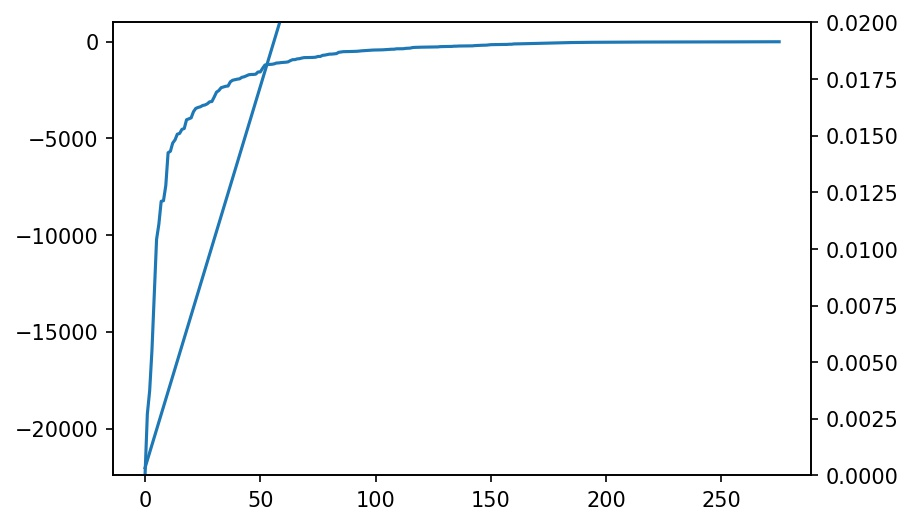

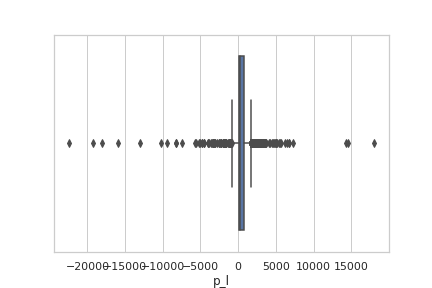

### Do sellers deserve a second chance?

* Of course, there are sellers who have performed very well in the past ... or maybe not.
* So... we analyzed the 50 sellers and how they have performed over time.

In [5]:
import pandas as pd
import numpy as np

from olist.seller import Seller
from olist.order import Order
from olist.data import Olist

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt

features = ['seller_id','seller_city','seller_state','date_first_sale', 'date_last_sale','n_orders','quantity',
                'quantity_per_order','sales']

#Cost Variables
cost_1_star = 100
cost_2_star = 50
cost_3_star = 40

#Income Variables
pct_incom_sales = 0.10
charg_month = 80

#Get Data
sellers = Seller().get_training_data()
information_df = sellers[features].copy()

orders_reviews = Order().get_review_score()
matching_table = Olist().get_matching_table()


#Calculate Numbers of months that the seller is working with us

information_df['n_months'] = ((information_df.date_last_sale - information_df.date_first_sale)/np.timedelta64(1, 'M'))
information_df['n_months'] = information_df['n_months'].apply(np.ceil)

#Where n_months = 0 --> 1
information_df['n_months'] = np.where(information_df['n_months'] == 0, 1, information_df['n_months'])


features = ['seller_id','seller_city','seller_state','date_first_sale', 'date_last_sale','n_orders','quantity',
                'quantity_per_order','sales', 'n_months']


#from olist.order import Order
#from olist.data import Olist


#orders_reviews = Order().get_review_score()
#matching_table = Olist().get_matching_table()


matching_table = matching_table[['order_id', 'seller_id']].drop_duplicates()
reviews_df = matching_table.merge(orders_reviews, on='order_id')

reviews_df = reviews_df[['seller_id','review_score']]

#Create new Numbers X stars by Sellers

for stars in range(1, 6, 1):
    reviews_df[f'n_{stars}_star'] = np.where(reviews_df['review_score'] == stars, 1, 0)
    
#Groupby 'Seller' 

reviews_df = reviews_df.groupby('seller_id').sum()
reviews_df.drop(['review_score'], axis=1, inplace=True)

#Create our final DataFrame with ALL the information that we need.
information_df = information_df.merge(reviews_df, on='seller_id')



#cost_of_bad_reviews = n_1_star*100 + n_2_star*50 + n_3_star*40
information_df['cost_of_bad_reviews'] = information_df['n_1_star'] * cost_1_star + information_df['n_2_star'] * cost_2_star + \
information_df['n_3_star'] * cost_3_star 



#Income
information_df['income'] = information_df['n_months'] * charg_month + information_df['sales'] * pct_incom_sales


#P&L
information_df['p_l'] = information_df['income'] - information_df['cost_of_bad_reviews']




pct_seller_loo = information_df[['seller_id', 'p_l','income','cost_of_bad_reviews', 'n_months']].copy()


pct_seller_loo.sort_values(by=['p_l'], inplace = True, ignore_index = True)


#Test.drop(['perc_seller'], axis=1, inplace=True)
pct_seller_loo.insert(0, 'perc_seller', range(1, 1 + len(pct_seller_loo)))
pct_seller_loo['perc_seller'] = pct_seller_loo['perc_seller']/pct_seller_loo['perc_seller'].count()


data = Olist().get_data()

df_a = data['orders']
df_b = data['order_reviews']
df_c = data['order_items']

h = df_a.merge(df_b, on='order_id', how='outer')
info_total = h.merge(df_c, on='order_id', how='outer')



features_all = ['order_id','customer_id','order_status','order_purchase_timestamp','order_approved_at',
                'order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','review_id',
                'review_score','review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp',
                'order_item_id','product_id','seller_id','shipping_limit_date','price','freight_value']

features_leak = ['order_status','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
                 'order_estimated_delivery_date','review_id','review_comment_title','review_comment_message',
                 'review_creation_date','review_answer_timestamp','product_id','shipping_limit_date','freight_value',
                 'order_id','customer_id','order_item_id']
                

features = ['seller_id','review_score','price','order_purchase_timestamp']

hist_df= info_total[features].copy()
hist_df['order_purchase_timestamp'] = pd.to_datetime(hist_df['order_purchase_timestamp'])  

for stars in range(1, 6, 1):
    hist_df[f'n_{stars}_star'] = np.where(hist_df['review_score'] == stars, 1, 0)
    
historical= hist_df.groupby('seller_id').resample('M', on='order_purchase_timestamp').sum()


a = hist_df[['order_purchase_timestamp']]
a =a.resample('M', on='order_purchase_timestamp').sum()
a=pd.DataFrame(a.index)

a['one'] = 1

b = hist_df['seller_id'].unique()

b=pd.DataFrame(b)
b['one'] = 1

c=b.merge(a, on = 'one').drop(columns = 'one', axis= 1)


c['review_score'] =0

c['price'] =0
c['n_1_star'] =0
c['n_2_star'] =0
c['n_3_star'] =0
c['n_4_star'] =0
c['n_5_star'] =0

c.rename(columns = {0:'seller_id'}, inplace = True)
final_df_hh = pd.concat([c, hist_df])


seller_df = pd.DataFrame(pct_seller_loo['seller_id'][0:50])
seller_df = seller_df.merge(information_df[['seller_id','date_first_sale','date_last_sale']], on = 'seller_id')
seller_df = seller_df.merge(final_df_hh, on = 'seller_id', how ='left')

seller_df['delete'] = np.where(seller_df['order_purchase_timestamp']<seller_df['date_first_sale'] , 1, 0)
seller_df['delete'] = np.where(seller_df['order_purchase_timestamp']>seller_df['date_last_sale'] , 1,
                               seller_df['delete'] )

seller_df = seller_df[seller_df['delete'] == 0]

feature_seller = ['seller_id','order_purchase_timestamp','review_score','price','n_1_star','n_2_star','n_3_star','n_4_star','n_5_star']
seller_df = seller_df[feature_seller]

seller_df = seller_df.groupby('seller_id').resample('M', on='order_purchase_timestamp').sum()

seller_df['pl'] = (seller_df['price'] * pct_incom_sales + charg_month) - (seller_df['n_1_star'] * cost_1_star + seller_df['n_2_star'] * 
                                                        cost_2_star + seller_df['n_3_star'] * cost_3_star)

seller_df = seller_df[['pl']].copy()
seller_df.reset_index(inplace=True)

seller_df = seller_df.rename(columns = {'order_purchase_timestamp':'date'})

seller_df = seller_df.pivot_table(values = 'pl',index = ['date'], columns = 'seller_id')

#seller_df = seller_df.pivot_table(values = 'pl',index = ['date'], columns = 'seller_id')
seller_df.fillna(0, inplace=True)

seller_df.iloc[:, 0:-1] = seller_df.iloc[:, 0:-1].cumsum()











In [6]:
seller_df

seller_id,06a2c3af7b3aee5d69171b0e14f0ee87,1025f0e2d44d7041d6cf58b6550e0bfa,128639473a139ac0f3e5f5ade55873a5,16090f2ca825584b5a147ab24aa30c86,1835b56ce799e6a4dc4eddc053f04066,18a349e75d307f4b4cc646a691ed4216,1900267e848ceeba8fa32d80c1a5f5a8,1ca7077d890b907f89be8c954a02686a,1da3aeb70d7989d1e6d9b0e887f97c23,1f50f920176fa81dab994f9023523100,...,cca3071e3e9bb7d12640c9fbe2301306,d2374cbcbb3ca4ab1086534108cc3ab7,d91fb3b7d041e83b64a00a3edfb37e4f,dc4a0fc896dc34b0d5bfec8438291c80,e5a3438891c0bfdb9394643f95273d8e,e9779976487b77c6d4ac45f75ec7afe9,ea8482cd71df3c1969d7b9473ff13abc,ef506c96320abeedfb894c34db06f478,f457c46070d02cadd8a68551231220dd,f8db351d8c4c4c22c6835c19a46f01b0
date,,,,,,,,,,,,,,,,,,,,,
2016-10-31,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,155.890,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00
2016-11-30,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,235.890,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00
2016-12-31,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,315.890,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00
2017-01-31,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-326.660,0.000,0.000,0.000,0.000,0.000,0.000,86.697,0.00,10.35
2017-02-28,0.000,0.000,0.000,6.995,0.000,0.000,0.000,0.000,0.000,0.000,...,-1515.490,31.390,10.800,86.990,0.000,0.000,0.000,-69.122,0.00,-42.61
2017-03-31,0.000,0.000,0.000,26.790,0.000,0.000,0.000,0.000,82.598,0.000,...,-2579.814,-522.470,90.800,220.910,0.000,22.000,0.000,-610.653,0.00,-457.34
2017-04-30,0.000,0.000,0.000,118.788,0.000,0.000,0.000,0.000,80.391,9.950,...,-2661.904,-1606.750,209.600,80.470,0.000,-155.820,0.000,-660.671,0.00,-125.18
2017-05-31,0.000,0.000,27.560,213.786,0.000,0.000,-204.087,0.000,-212.321,-8.220,...,-3311.884,-2090.760,411.249,-274.717,55.978,-99.871,0.000,-1336.402,0.00,-48.13
2017-06-30,0.000,0.000,72.050,338.686,0.000,0.000,-500.910,0.000,-112.128,149.650,...,-3485.428,-2601.200,-129.392,-562.673,149.208,-194.044,0.000,-1577.217,0.00,-54.06


#### It's sad ... but no Seller deserves a second chance ...

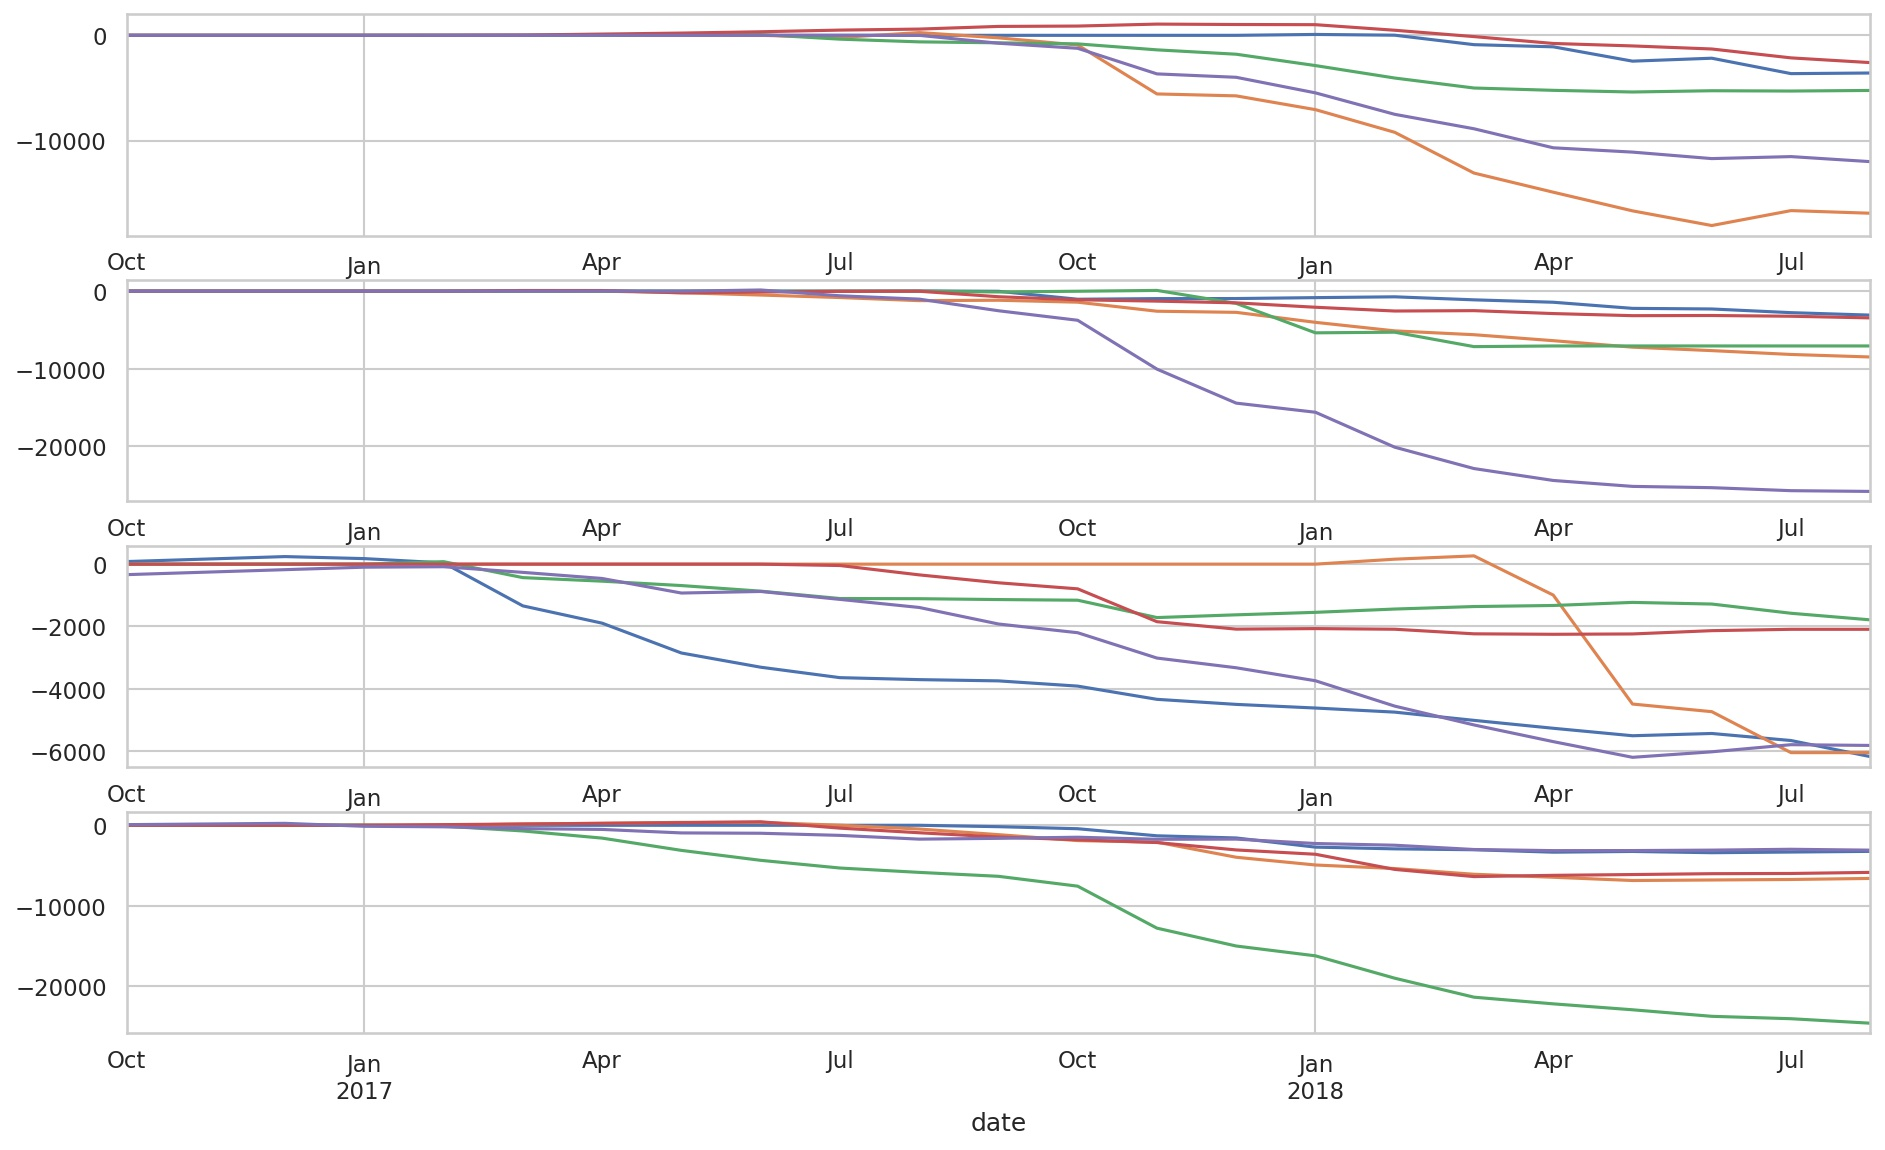

# All sellers should be fired if they do not have good results in 3 months.